<a href="https://colab.research.google.com/github/MNoumanAbbasi/Fruit-Classifier/blob/master/fruit_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit classifier
*by Nouman Abbasi*  

Deep learning model that can classify **120** different fruits and vegetables. Uses the fastai library.  
**Note:** This notebook was run using Google Colab.  
*This project is based on the Practical Deep Learning for Coders v3 MOOC.*

In [0]:
from fastai.vision import *

## Getting the data

For the data we will be using [Fruits 360](https://www.kaggle.com/moltean/fruits) dataset from Kaggle.  

There are two ways we can download and store our data:  

1.   First is we store our data on the Google Colab runtime server. Storing on the server means that file manipulation like unzipping will take little time. However, the data will be removed after the runtime shuts down/reconnects and you will have to redownload the data again.
2.   Second option is we can mount Google Drive and download and store our data there. The data will be stored permanently, but the issue is file manipulation, e.g. unzipping, will take a significant amount of time especially if the dataset is large.  

We will proceed with the first option. However, if you're interested in trying the second option, [here](https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166) is a very good tutorial on how to mount your Google Drive in your Google Colab notebook.  

We use the Kaggle API to get the data.  
Go to your Kaggle account and create an API token. A json file will be downloaded.  
Running the following code will prompt you to upload the kaggle.json file.

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"noumanabbasi","key":"0d71772554b13167fda3f384ce0297f5"}'}

Now run commands to install kaggle library and download the required dataset to a folder named 'kaggle' in your Google Drive.

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

!kaggle datasets download -d moltean/fruits

kaggle.json
fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip -q /content/fruits.zip -d /content/
!ls

replace /content/fruits-360_dataset/fruits-360/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
 fruits-360_dataset   fruits.zip  'kaggle (1).json'   kaggle.json   sample_data


Next we load the data.

In [0]:
path = Path('fruits-360_dataset/fruits-360')
np.random.seed(42)

data = ImageDataBunch.from_folder(path, train="Training", valid="Test",
        ds_tfms=get_transforms(), num_workers=4).normalize(imagenet_stats)

It is always good to take a look at your dataset before you start training your model.  
Lets take a look at our loaded data.

In [0]:
data.classes

In [0]:
data.c, len(data.train_ds), len(data.valid_ds)

(120, 60498, 20622)

In [0]:
data.show_batch(rows=3, figsize=(7,8))

## Training

We train our model using a technique called transfer learning where we use a pretrained model and train it on our own dataset. We will be using the resnet34 model which has already been trained on the ImageNet dataset. 

In [0]:
learner = cnn_learner(data, models.resnet34, metrics=accuracy)

In [0]:
learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.056933,0.051240,0.984628,02:29


In [0]:
learner.save('stage-1')

## Fine-tuning

So far we trained a freezed version of the resnet34 model. That is only the last few layers of the model were trained.  

Now we will try unfreezing the model and then learning the model to further fine-tune our model. However, training an unfreezed model will take more time.  

In [0]:
learner.unfreeze()

In [0]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


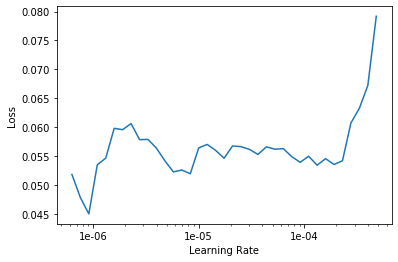

In [0]:
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(1, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.007688,0.021366,0.993987,02:36


With just one more epoch, we are able to reach an impressive 99.4% accuracy for our fruit classifier.

In [0]:
learner.save('stage-2')

## Further look into our model

Seeing where our model made the most mistakes.

In [0]:
learner.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learner)

In [0]:
interp.most_confused(min_val=5)

[('Apple Red 2', 'Apple Braeburn', 30),
 ('Passion Fruit', 'Plum 3', 23),
 ('Eggplant', 'Melon Piel de Sapo', 17),
 ('Apple Golden 2', 'Apple Golden 3', 16),
 ('Pepino', 'Peach Flat', 14),
 ('Eggplant', 'Beetroot', 13),
 ('Apple Braeburn', 'Nectarine', 5)]

## For Production Purposes

We export our model as 

In [0]:
learner.export()

In [0]:
!ls /content/fruits-360_dataset/fruits-360/

export.pkl  models  readme.md  test-multiple_fruits
LICENSE     papers  Test       Training


Checking our prediction of our model before we save our model.

In [0]:
defaults.device = torch.device('cpu')

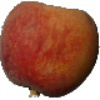

In [0]:
img = open_image(path/'Training/Peach/190_100.jpg')
img

In [0]:
learn = load_learner(path)

In [0]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class, outputs[pred_idx]

(Category Peach, tensor(1.0000))

We finally download our trained model by running the below command. (If the command does not work, try manually downloading by going to View -> Table of contents -> Files). The file is around 80 MB so will take time for Google Colab to fetch it.

In [0]:
files.download('/content/fruits-360_dataset/fruits-360/export.pkl')

## Final touches

I finally used my trained and ready model to deploy a simple fruit classifier web app that you can check out here.  

If you are interested in deploying your machine learning model, you can raed this amazing tutorial [here](https://towardsdatascience.com/how-to-deploy-your-machine-learning-web-app-to-digital-ocean-64bd19ce15e2).  